In [387]:
##########################################
## SET FOR DISPLAY FORMAT
##########################################

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## Importing data

### Setting configuration for bigquery
### Import data in bigquery to pandas 

In [3]:
##########################################
## CONFIG FOR BIGQUERY
##########################################

from bigquery import get_client

# BigQuery project id as listed in the Google Developers Console.
project_id = 'springboard-project'

# Service account email address as listed in the Google Developers Console.
service_account = 'python-pandas@springboard-project.iam.gserviceaccount.com'

# PKCS12 or PEM key provided by Google.
key = '/Users/tancy/SpringBoardProject-b3a58f067389.p12'

client = get_client(project_id, service_account=service_account,
                    private_key_file=key, readonly=True)

In [4]:
##########################################
## BIGQUERY TO DATAFRAME
##########################################

import pandas as pd

# to communicate with Google BigQuery
from pandas.io import gbq

amazon_book_sample_query = """
SELECT
    reviewerID,
    asin,
    unixReviewTime,
    overall,
    reviewText,
    summary,
    helpful_vot,
    tot_vot,

FROM
    (SELECT * FROM [springboard-project:AmazonReview.book2_small_sample])
    
"""

try:
    ABS_df = gbq.read_gbq(amazon_book_sample_query, project_id=project_id)
except:
    print 'Error reading the dataset'


Requesting query... ok.
Query running...
Query done.
Processed: 870.3 kb

Retrieving results...
  Got page: 1; 100.0% done. Elapsed 8.58 s.
Got 1019 rows.

Total time taken 8.68 s.
Finished at 2016-11-07 12:37:08.


In [5]:
## check import data
ABS_df.head(2)

,reviewerID,asin,unixReviewTime,overall,reviewText,summary,helpful_vot,tot_vot
0,A34WV7011DN53P,1416599142,1260230400,4,I enjoyed this book alot. It was really compe...,A Pretty Good Read!,0,0
1,A3PQ17R44Q5UJK,1925047415,1393804800,2,The twist ending made little to no sense. See...,Meh,0,1


In [430]:
##########################################
## DESCRIPTIVE STATISTICS
##########################################

### How many unique reviewers?
reviewer_prop = float(len(ABS_df.reviewerID.unique()))/len(ABS_df.index)
print "Number of unique reviewers:" + str(reviewer_prop)

### How many unique products?
product_prop = float(len(ABS_df.asin.unique()))/len(ABS_df.index)
print "Number of unique products:" + str(product_prop)

### average star score
print("Average rating score: " + str(ABS_df.overall.mean()))

### average helpful 
ABS_df['help_prop'] = ABS_df.helpful_vot.div(ABS_df.tot_vot, axis=0)
print("Average helpful pcd:" + str(ABS_df.help_prop.mean()))

### no helpfulness vote
novote = ABS_df.tot_vot[ABS_df.tot_vot == 0].count()
nonvote_prop = float(novote)/len(ABS_df.index)
print ("Non helpful vote:" + str(nonvote_prop))


Number of unique reviewers:0.990186457311
Number of unique products:0.988223748773
Average rating score: 4.26594700687
Average helpful pcd:0.725296828321
Non helpful vote:0.454367026497


## Preliminary Analysis
### Distribution of star rating (1 to 5)
### Frequency of reviews by reviewers

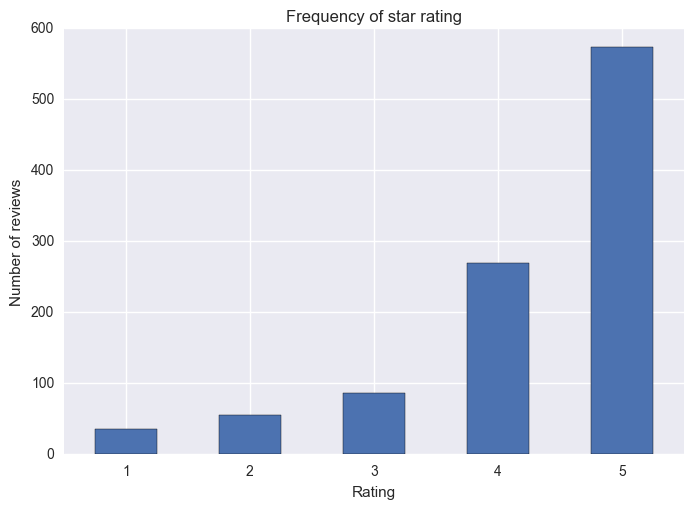

In [413]:
##########################################
## DISTRIBUTION OF STAR RATING
########################################## 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

ABS_df.groupby('overall').size().plot(kind='bar')
plt.title("Frequency of star rating")
plt.xlabel("Rating")
plt.ylabel("Number of reviews")
plt.xticks(rotation=0)
plt.show()



max reviews:5


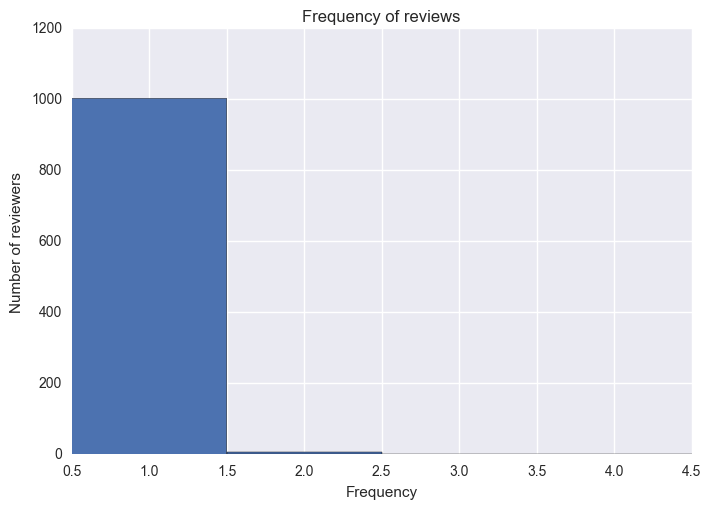

In [394]:
##########################################
## FREQUENCY OF REVIEWS BY REVIEWERS
########################################## 
import numpy as np

reviewer_count = ABS_df.reviewerID.value_counts()
print "max reviews:" + str(max(reviewer_count))

plt.hist(reviewer_count, bins=np.arange(reviewer_count.min(), reviewer_count.max()+1)-0.5)
plt.title("Frequency of reviews")
plt.xlabel("Frequency")
plt.ylabel("Number of reviewers")
plt.show()

## Preliminary set of features to helpfulness
### Distribution of rating for helpfulness
### Length of texts by reviewer
### Length of summary by reviewer
### Total number of votes
### Time different from first review
### Number of reviews of a product

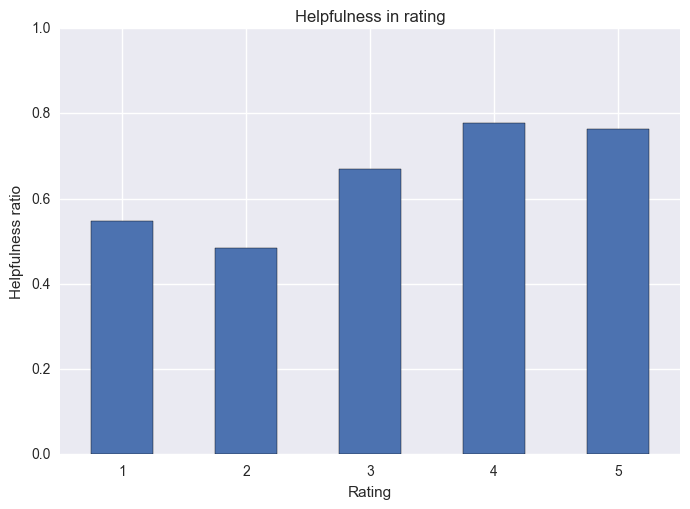

In [412]:
##########################################
## DISTRIBUTION OF RATING FOR HELPFULNESS
########################################## 

ABS_df.groupby('overall')['help_prop'].mean().plot(kind='bar')
plt.title("Helpfulness in rating")
plt.xlabel("Rating")
plt.ylabel("Helpfulness ratio")
plt.ylim([0, 1])
plt.xticks(rotation=0)
plt.show()

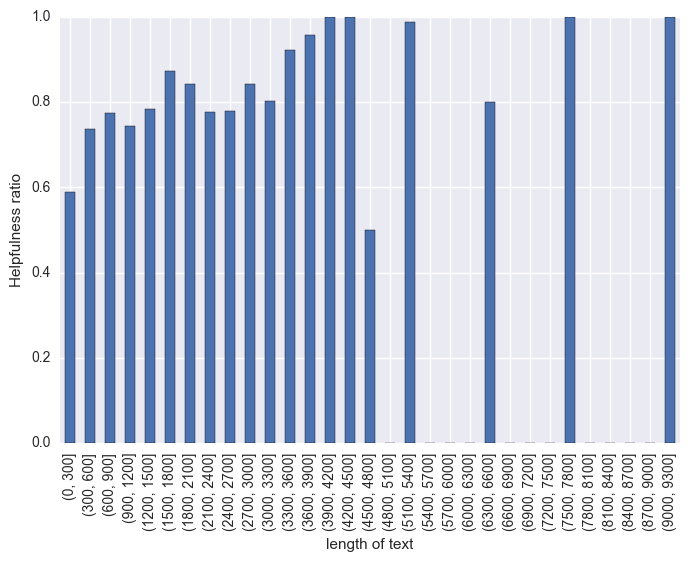

In [463]:
##########################################
## HELPFULNESS FOR LENGTH OF TEXT
########################################## 

### consider all possible
ABS_df['text_len'] = ABS_df.reviewText.apply(len)
maxTextLen = max(ABS_df.text_len)
ABS_df.groupby(pd.cut(ABS_df['text_len'], np.arange(0,maxTextLen+300,300)))['help_prop'].mean().plot(kind='bar')
plt.xlabel("length of text")
plt.ylabel("Helpfulness ratio")
plt.ylim([0, 1])

plt.show()

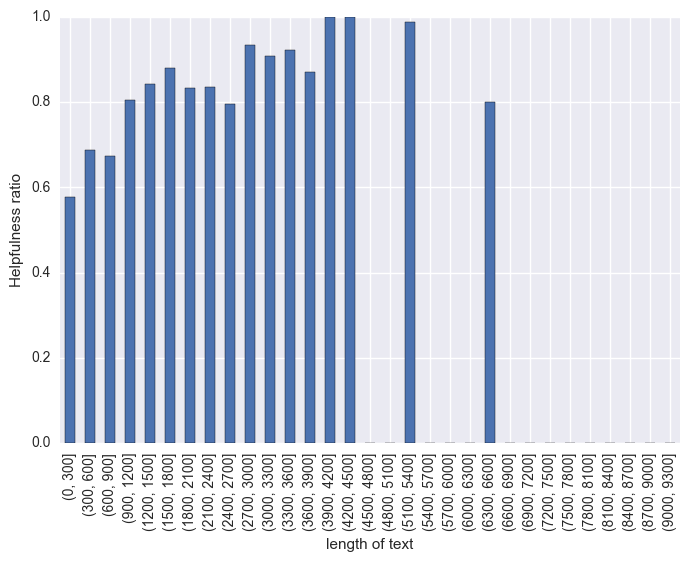

In [467]:
### select total vote > 2

ABS_df_sel = ABS_df[ABS_df.tot_vot>2]
maxTextLen = max(ABS_df.text_len)
ABS_df_sel.groupby(pd.cut(ABS_df_sel['text_len'], np.arange(0,maxTextLen+300,300)))['help_prop'].mean().plot(kind='bar')
plt.title("total_vote>2")
plt.xlabel("length of text")
plt.ylabel("Helpfulness ratio")
plt.ylim([0, 1])

plt.show()


## Data Cleaning and Text Preprocessing
### * replaces all punctuation with spaces,
### * converts the input string to lower case, 
### * splits the string to words
### * removes stop-words 


In [468]:
##########################################
## LABEL SENTIMENT OF REVIEW
##########################################

def label_Sentiment(row):
    if row['overall'] <= 2:
       return "negative"
    if row['overall'] == 3:
       return "neural"
    if row['overall'] >= 4:
        return "positive"

ABS_df['sentiment'] = ABS_df.apply(label_Sentiment, axis=1)

ABS_df.head(3)


,reviewerID,asin,unixReviewTime,overall,reviewText,summary,helpful_vot,tot_vot,help_prop,text_len,labelSent,sentiment
0,A34WV7011DN53P,1416599142,1260230400,4,I enjoyed this book alot. It was really compe...,A Pretty Good Read!,0,0,NaN,1183,positive,positive
1,A3PQ17R44Q5UJK,1925047415,1393804800,2,The twist ending made little to no sense. See...,Meh,0,1,0.0,107,negative,negative
2,A3TJ5MK5669HID,B00IMP3N86,1403827200,5,Can you say panty melting!?! I just Loved Fate...,Book Talk Reviews,1,1,1.0,762,positive,positive


In [97]:
##########################################
## FUNCTION TO CLEAN REVIEWS TO WORDS
##########################################

import re, string, nltk
from nltk.corpus import stopwords
    
def review2words(raw_review):
    remove = string.punctuation
    # keep surprise characters
    remove = remove.replace("!", "") # don't remove !
    remove = remove.replace("?", "") # don't remove ?
    pattern = r"[{}]".format(remove) # create the pattern

    # 1. replaces punctuation with spaces
    review_words=raw_review.str.replace(pattern, "")

    # 2. converts the input string to lower case
    review_words_low = review_words.str.lower()

    # 3. splits the string and ? ! to words 
    review_words_low2 = review_words_low.apply(nltk.word_tokenize)
    
    # 4. removes stop-words
    stops = set(stopwords.words("english")) # searching a set is faster than a list
    meaningful_words = review_words_low2.apply(lambda x: [w for w in x if w not in stops])    
    
    ## if necessary to do following clean text ##
    # 5. Stemming - strip off affixes
    # porter = nltk.PorterStemmer()
    # meaningful_words2 = meaningful_words.apply(lambda x: [porter.stem(t) for t in x])
    
    # 6. Lemmatizing - the word is from a dictionary 
    # wnl = nltk.WordNetLemmatizer()
    # clean_words = meaningful_words2.apply(lambda x: [wnl.lemmatize(t) for t in x])
    
    return(meaningful_words)


In [98]:
##########################################
## PROCESS TO CLEAN REVIEWS TO WORDS
##########################################

clean_s = review2words(ABS_df.reviewText)
clean_s.name="cleanText"

## merge back to dataframe
clean_ABS_df = pd.concat([ABS_df,clean_s],axis=1)
clean_ABS_df.head(3)

,reviewerID,asin,unixReviewTime,overall,reviewText,summary,helpful_vot,tot_vot,help_prop,text_len,labelSent,sentiment,cleanText
0,A34WV7011DN53P,1416599142,1260230400,4,I enjoyed this book alot. It was really compe...,A Pretty Good Read!,0,0,NaN,1183,positive,positive,"[enjoyed, book, alot, really, compelling, meli..."
1,A3PQ17R44Q5UJK,1925047415,1393804800,2,The twist ending made little to no sense. See...,Meh,0,1,0.0,107,negative,negative,"[twist, ending, made, little, sense, seemed, q..."
2,A3TJ5MK5669HID,B00IMP3N86,1403827200,5,Can you say panty melting!?! I just Loved Fate...,Book Talk Reviews,1,1,1.0,762,positive,positive,"[say, panty, melting, !, ?, !, loved, fate, fa..."


In [372]:
##########################################
## FUNCTION TO COUNT FREQUENCY OF WORDS
##########################################

def count_freq_words(cleanDat):
    # extract clean text to a list
    review_lists = cleanDat

    # count frequency of each word
    review_words = []
    for wordList in review_lists:
        review_words += wordList

    # frequency dist of words
    fdist = nltk.FreqDist(review_words)

    # take top 10% common words 
    N = int(0.1*len(fdist.keys()))
    mostcommon = fdist.most_common(N)

    mclist = []
    for i in range(len(mostcommon)):
        mclist.append(mostcommon[i][0])

    # mclist contains second-most common set of 100 words
    # keep all occurrences of the words in mclist
    top_review_words = [w for w in review_words if w in mclist]
    
    return fdist, top_review_words


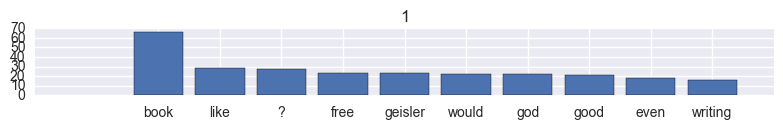

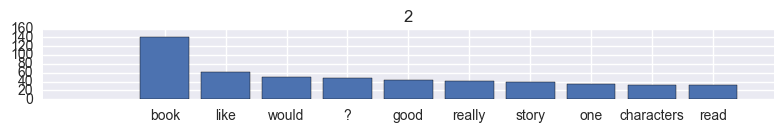

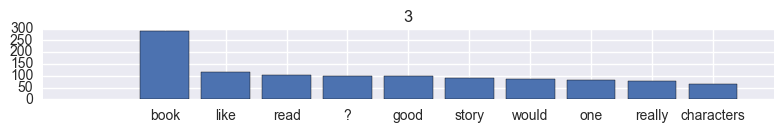

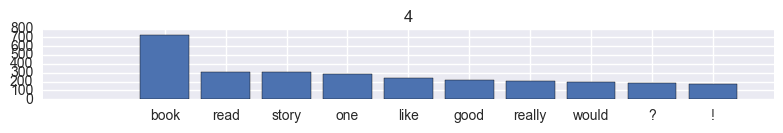

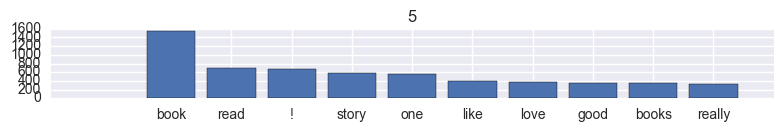

In [17]:
##########################################
## TOP WORDS OF EACH RATING
##########################################

try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict
    
# split words by star rating[1 to 5]
rating_ABS_df = clean_ABS_df.groupby('overall')['cleanText'].apply(lambda x: x.sum()).reset_index()


ratingText_ls=[]
for i in range(1, len(rating_ABS_df)+1):
    all_tops=count_freq_words(rating_ABS_df.cleanText[:i])[0]
    sort_tops = OrderedDict(sorted(all_tops.items(), key=lambda t: t[1], reverse=True)[:10]) # dictionary sorted by value    
    ratingText_ls.append({'overall': i, 'FreqDist': sort_tops})
    temp = 510+i
    plt.subplot(temp)
    ax = plt.subplot(temp)
    plt.title(str(i))
    plt.bar(range(len(sort_tops)), sort_tops.values(), align="center")
    plt.xticks(range(len(sort_tops)), list(sort_tops.keys()))
    plt.tight_layout()
    plt.show()

ratingText_df = pd.DataFrame(ratingText_ls)


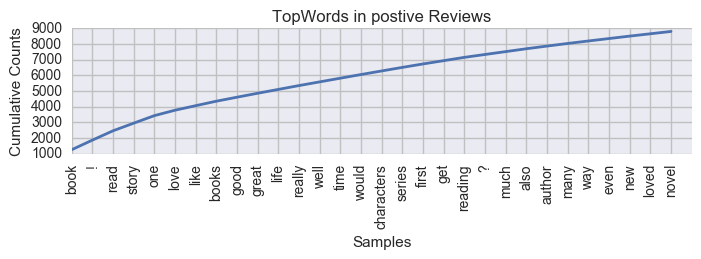

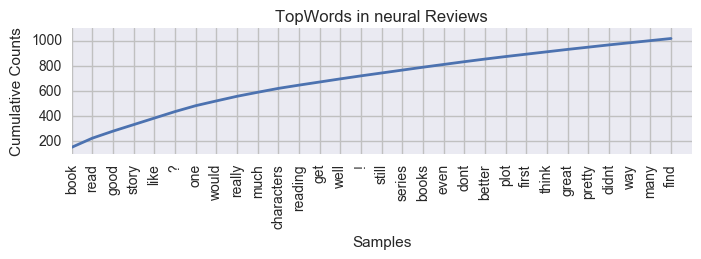

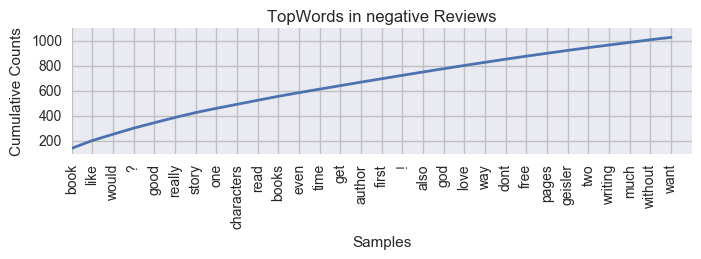

In [469]:
##########################################
## TOP WORDS OF POSITIVE, NEURAL, NEGATIVE 
##########################################

### extract clean text to a list
senti_ABS_df = clean_ABS_df.groupby('sentiment')['cleanText'].sum().reset_index()    
senti_ABS_df.columns = ['sentiment','cleanText']

## positive reviewers
pos_ABS_df = senti_ABS_df[senti_ABS_df.sentiment=='positive']
pos_whole_words = count_freq_words(pos_ABS_df.cleanText)
pos_whole_words_dist = pos_whole_words[0]
pos_top_words = pos_whole_words[1]

## neural reviewers
neur_ABS_df = senti_ABS_df[senti_ABS_df.sentiment=='neural']
neur_whole_words = count_freq_words(neur_ABS_df.cleanText)
neur_whole_words_dist = neur_whole_words[0]
neur_top_words = neur_whole_words[1]

## negative reviewers
neg_ABS_df = senti_ABS_df[senti_ABS_df.sentiment=='negative']
neg_whole_words = count_freq_words(neg_ABS_df.cleanText)
neg_whole_words_dist = neg_whole_words[0]
neg_top_words = neg_whole_words[1]

topN = 30 # select top 30
plt.subplot(311)
plt.title("TopWords in postive Reviews")
pos_whole_words_dist.plot(topN, cumulative=True)

plt.figure(1)
plt.subplot(312)
plt.title("TopWords in neural Reviews")
neur_whole_words_dist.plot(topN, cumulative=True)

plt.subplot(313)
plt.title("TopWords in negative Reviews")
neg_whole_words_dist.plot(topN, cumulative=True)
plt.show()


In [108]:
##########################################
## FUNCTION OF WORD CLOUD 
##########################################

### count frequency of words
### generate word cloud of all text
### split word cloud of postive rating and negative rating

### need wordcloud package by Andreas Mueller
### need Python’s imaging library PIL

from wordcloud import WordCloud

def wordcloud_fig(import_top_words):
    #Convert all the required text into a single string here 
    #and store them in word_string
    top_review_str = ' '.join(import_top_words)

    wordcloud = WordCloud(#font_path='/Users/tancy/Library/Fonts/sans-serif.ttf',
                              background_color='black',
                              width=800,
                              height=600
                             ).generate(top_review_str)

    return(wordcloud)

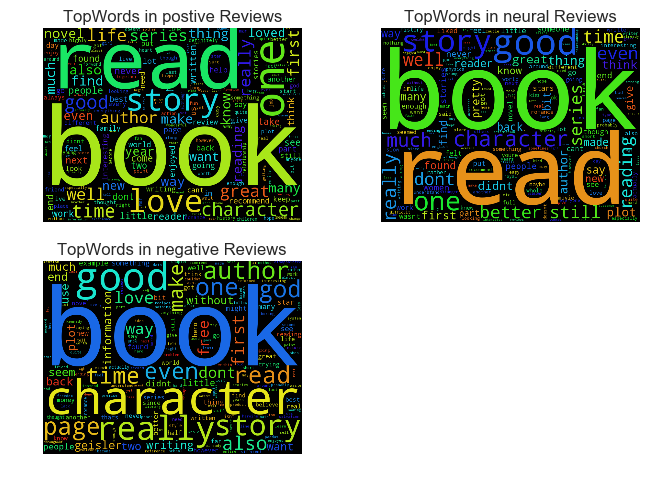

In [470]:
##########################################
## PROCESS TO WORD CLOUD 
##########################################

plt.figure(1)
plt.subplot(221)
plt.imshow(wordcloud_fig(pos_top_words))
plt.title("TopWords in postive Reviews")
plt.axis('off')

plt.subplot(222)
plt.imshow(wordcloud_fig(neur_top_words))
plt.title("TopWords in neural Reviews")
plt.axis('off')

plt.subplot(223)
plt.imshow(wordcloud_fig(neg_top_words))
plt.title("TopWords in negative Reviews")
plt.axis('off')
plt.show()


## Sentiment analysis
### Naive Bayes classification 
#### 1) label the sentiment based on reviewers' star rating
#### 2) feature extract
#### 3) NaiveBayesClassifier
#### 4) find their informative info
#### 5) accuracy

In [ ]:
from nltk import NaiveBayesClassifier
from nltk import FreqDist
from nltk.classify import accuracy

In [472]:
##########################################
## FUNCTION TO PROCESS FEATURES 
##########################################

### features of positive, neural, negative
def process_features(senti_input_df):
    reviewList = []
    for row in range(len(senti_input_df)):
        sentiment = senti_input_df.sentiment[row]
        text = senti_input_df.cleanText[row]
        reviewList.append((text, sentiment))

    # Get reveiew features
    word_features = count_freq_words(senti_input_df.cleanText)[1]
    word_features = list(set(word_features))

    return reviewList, word_features

## select the input data
processDat = process_features(senti_ABS_df) #senti_ABS_df

In [473]:
##########################################
## FUNCTION TO EXTRACT FEATURES 
##########################################

### extract_features
def extract_features(reviews):
    review_words = set(reviews)
    features = {}
    for word in processDat[1]:
        features['contains(%s)' % word] = (word in review_words)
    return features

# Extract feature for all reviewers
training_set = nltk.classify.util.apply_features(extract_features, processDat[0])

In [471]:
#extract_features(["disappointing","book"])

In [474]:
##########################################
## TEST CLASSIFIER 
##########################################

# Train the classifier 
NBClassifier = nltk.NaiveBayesClassifier.train(training_set)

# Test the classifier
testSentence = "boring book?" # treat as pd.Series
testSentence = review2words(pd.Series([testSentence]))
# count frequency of each word
testSentence_dic = []
for wordList in testSentence:
    testSentence_dic += wordList

print "Output Sentiment:", NBClassifier.classify(extract_features(testSentence_dic))
testSentence_dic

Output Sentiment: neural


['boring', 'book', '?']

In [475]:
##########################################
## PRINT INFORMATIVE FEATURES 
##########################################

## print informative features about the classifier
print NBClassifier.show_most_informative_features(20)

Most Informative Features
        contains(caring) = True           neural : positi =      1.0 : 1.0
        contains(boring) = True           neural : positi =      1.0 : 1.0
         contains(front) = True           neural : positi =      1.0 : 1.0
         contains(using) = True           neural : positi =      1.0 : 1.0
        contains(market) = True           negati : positi =      1.0 : 1.0
        contains(thrown) = True           neural : positi =      1.0 : 1.0
          contains(much) = True           neural : positi =      1.0 : 1.0
         contains(major) = True           neural : positi =      1.0 : 1.0
         contains(peter) = False          neural : negati =      1.0 : 1.0
    contains(characters) = True           neural : positi =      1.0 : 1.0
     contains(testament) = True           neural : positi =      1.0 : 1.0
        contains(thanks) = True           negati : positi =      1.0 : 1.0
None


In [386]:
##print(nltk.classify.accuracy(NBClassifier, test_set))

NameError: name 'test_set' is not defined

## Simple test to NBClassifier
### generate text and sentiments
### fed to model

In [290]:
#### simple test this model

sampleText = pd.Series(["I hate the book! Doesn't make sense",
                       "funny, interesting, I learn a lot from this book",
                       "I love the book, the contents are fanstating",
                       "Disapponiting to read this book"])
sentiment = pd.Series(["negative","positive","positive","negative"])
sampleMdTest_df = pd.DataFrame({'rawText':sampleText, 'sentiment':sentiment})
sampleMdTest_df

sample_clean = review2words(sampleMdTest_df.rawText)
sample_clean.name="cleanText"
sample_clean_df = pd.concat([sampleMdTest_df,sample_clean],axis=1)
sample_clean_df= sample_clean_df.groupby('sentiment')['cleanText'].sum().reset_index()

sample_clean_df.columns = ['sentiment','cleanText']
sample_clean_df

,sentiment,cleanText
0,negative,"[hate, book, !, doesnt, make, sense, disapponi..."
1,positive,"[funny, interesting, learn, lot, book, love, b..."


## FOR SPARK

In [ ]:
# import PySpark and create SparkContext
from pyspark import SparkConf
from pyspark import SparkContext

spark_df = sqlContext.createDataFrame(ABS_df)

spark_df.take(1)

In [ ]:
## classification 
# what are common characteristics of these customers?

In [ ]:
## we imported PySpark and create a SparkContext

conf = SparkConf()
conf.setMaster('local[2]') #yarn-client
conf.setAppName('spark-nltk')
sc.stop()
sc = SparkContext(conf=conf) # tell Spark where and how to access cluster

In [ ]:
data = sc.textFile('file:///Users/tancy/nltk_data/corpora/state_union/1972-Nixon.txt')


In [ ]:
sqlc = SQLContext(sc) # create DataFrame
spark_df = sqlc.createDataFrame(amazon_book_sample_df)

In [ ]:
spark_df.distinct()

In [ ]:
def word_tokenize(x):
    import nltk
    return nltk.word_tokenize(x)

def pos_tag(x):
    import nltk
    return nltk.pos_tag([x])

words = spark_df.flatMap(word_tokenize)
print words.take(10)

pos_word = words.map(pos_tag)
print pos_word.take(5)

In [ ]:
print words.take(10)

In [ ]:
#



In [ ]:
txt.tail(5)

In [ ]:
from nltk.corpus import brown

In [ ]:
brown.words()

In [ ]:
## get word counts for each reviewer    
min(txt.apply(len))

In [ ]:
txt2 = txt.apply(lambda x: nltk.Text(x).count('happy'))
txt2.head()

In [ ]:
def content_fraction(text):
    stopwords = nltk.corpus.stopwords.words('english')
    content = [w for w in text if w.lower() not in stopwords]
    return len(content) / len(text)
content_fraction(nltk.corpus.reuters.words())

In [ ]:
## Dealing with Punctuation, Numbers and Stopwords: NLTK and regular expressions

a = amazon_book_sample_df.reviewText[1]
a



In [ ]:
### whether more reviewers more positive 

In [ ]:
### correlation between overall star rating and helpfulness
## higher star rating, higher helpfulness

In [ ]:
### length of word

In [ ]:
### sentiment of text

In [ ]:
### distribut of start rating

In [ ]:
### feature extract

In [ ]:
### NLTK Text Classification

In [ ]:
### clean text
## spelling check ASpell module
## replace punctuation with spaces
## all input string to lower case
## save into one column

In [ ]:
dd = [('Alice',1), ('Bob',2)]

In [ ]:
dd

In [ ]:
df = sqlc.createDataFrame(dd)

In [ ]:
df.collect()